In [2]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html

from io_data import loadSpatialDataset
from analyze import calcUmap, plotUmap
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics, linear_model
import random
from tqdm import tqdm
import re
import seaborn as sns

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

custom = {"axes.edgecolor": "grey"}
sns.set_style("whitegrid")
plt.rcParams['grid.alpha'] = 0.4
sns.set_palette("colorblind")

# Like colorblind_palette[4] for control, colorblind_palette[0] for test

In [3]:
def calcUmap(adata, nr_latent_dims: int = 15, n_neighbors: int = 25):
    ''' Calculate neighbourhood graph + umap
    '''
    sc.tl.pca(adata, svd_solver='arpack', n_comps=nr_latent_dims - 1)
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=nr_latent_dims)
    sc.tl.umap(adata)
    return adata

def plotUmap(adata, color: str, out_file: str = None, title: str = "", pattern_to_alpha: str = None, s: int =16, legend_fontsize: int = 20):
    """ Plot UMAP with a specified color in the .obs columns.


    Parameters
    ----------
    color : str
        color
    out_file : str
        out_file
    pattern_to_alpha : str
        pattern_to_alpha
    s : int
        Dotsize
    """
    if pattern_to_alpha is not None:
        alpha_list = [1 if pattern == pattern_to_alpha else 0.2 for pattern in adata.obs["pattern"]]
    else:
        alpha_list = None
    fig = sc.pl.umap(adata, color=color, title=title, s=s, alpha=alpha_list, legend_fontsize = legend_fontsize, return_fig = True)
    if out_file is None:
        plt.show()
    else:
        plt.savefig(out_file)

In [4]:
adata_split_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [4]:
adata_all_spots = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")
adata_mixed_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [86]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
choices = ['Low', 'Intermediate', 'Strong']
for adata in [adata_split_cellID]:
    conditions = [
        (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion'))
    ]

    adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [12]:
calcUmap(adata_split_cellID)

AnnData object with n_obs × n_vars = 1627152 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
    uns: 'test_cellIDs', 'train_cellIDs', 'pca', 'neighbors', 'umap'
    obsm: 'latent', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [93]:
import pickle

path = "/media/gambino/students_workdir/nynke/blurry/temp_objects/calcUmap_adata_split_cellID.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(adata_split_cellID, f)

In [94]:
path = "/media/gambino/students_workdir/nynke/blurry/temp_objects/calcUmap_adata_split_cellID.pkl"

with open(path, 'rb') as p:
    test = pickle.load(p)

In [26]:
adata_mixed_cellID

AnnData object with n_obs × n_vars = 1627152 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
    uns: 'pca', 'neighbors', 'umap', 'pattern_colors'
    obsm: 'latent', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

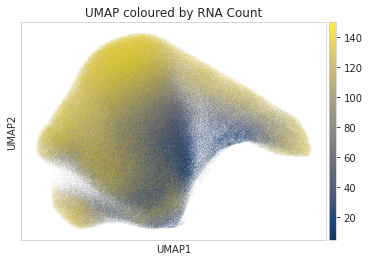

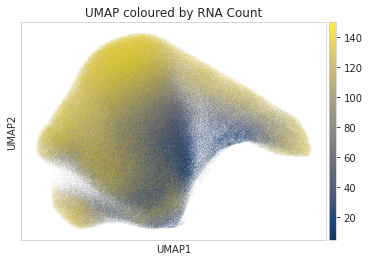

In [89]:
sc.pl.umap(adata_split_cellID, color="n_spots", title="UMAP coloured by RNA Count", cmap='cividis', alpha=0.9, s=0.2, legend_fontsize = 13, return_fig = True)

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


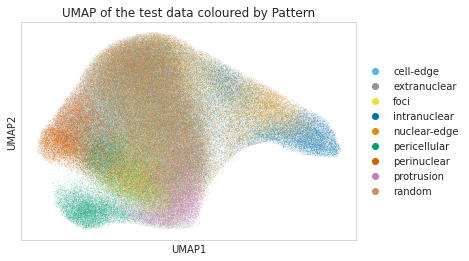

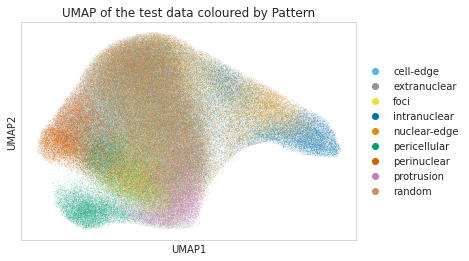

In [50]:
sc.pl.umap(adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])], color="pattern", title="UMAP of the test data coloured by Pattern", alpha=0.5, palette=new_palette, s=1, legend_fontsize = 10, return_fig = True)

In [38]:
colorblind_palette = sns.color_palette("colorblind")
colorblind_palette


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [79]:
adata_split_cellID.obs['pattern_strength'].unique()

[NaN]
Categories (3, object): ['Low' < 'Intermediate' < 'Strong']

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


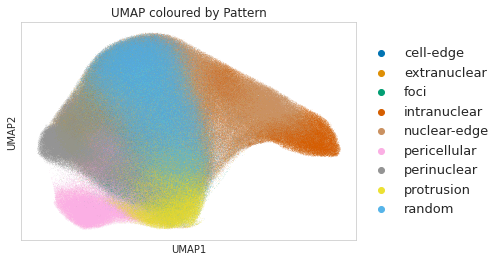

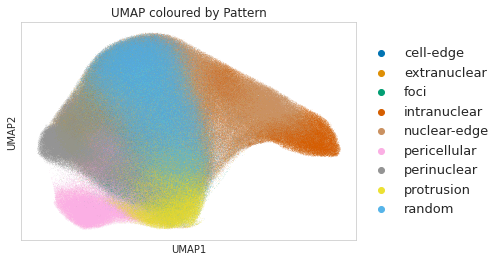

In [92]:
new_palette = colorblind_palette[:4] +colorblind_palette[5:]
sc.pl.umap(adata_split_cellID, color="pattern", title="UMAP coloured by Pattern", alpha=0.9, palette=new_palette, s=0.5, legend_fontsize = 13, return_fig = True)

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


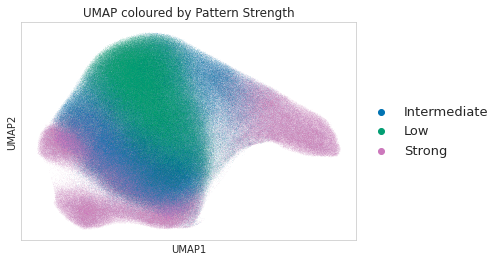

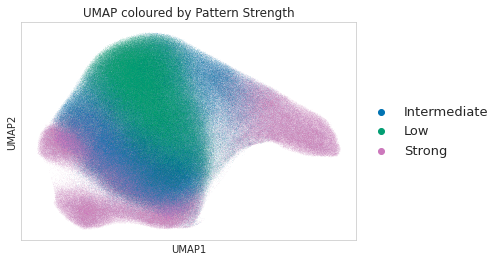

In [97]:
strength_palette = colorblind_palette[0:1] + colorblind_palette[2:3] + colorblind_palette[4:5]
sc.pl.umap(adata_split_cellID[adata_split_cellID.obs['pattern'] != 'random'], color="pattern_strength", title="UMAP coloured by Pattern Strength", alpha=0.9, palette=strength_palette, s=0.2, legend_fontsize = 13, return_fig = True)

In [ ]:
plotUmap(adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['train_cellIDs'])], "pattern", title="UMAP of the train data coloured by Pattern")

In [15]:
import pickle
path = f"temp_objects/calcUmap_adata_mixed_cellID.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(adata_mixed_cellID, f)

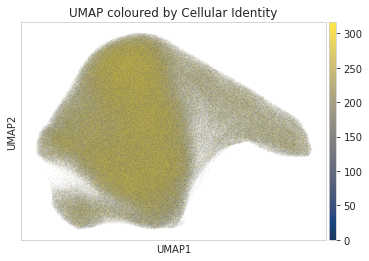

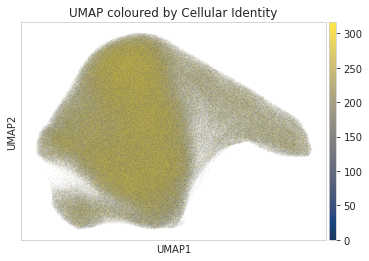

In [70]:
adata_split_cellID.obs['cell_id'] = adata_split_cellID.obs['cell_id'].astype(int)
sc.pl.umap(adata_split_cellID, color="cell_id", title="UMAP coloured by Cellular Identity", cmap='cividis', alpha=0.9, s=0.2, legend_fontsize = 13, return_fig = True)

In [25]:
reg = linear_model.LinearRegression()
reg.fit(adata.obsm['latent'], adata.obs['n_spots'])

LinearRegression()

In [28]:
reg.score(adata.obsm['latent'], adata.obs['n_spots'])

0.7986917400970786

In [39]:
df = pd.DataFrame(adata.obsm['latent'])
df['n_spots'] = adata.obs['n_spots']

In [51]:
spots = adata.obs['n_spots'].to_list()
df['n_spots'] = spots
df

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,n_spots
0,-2.172202,1.679101,-0.529711,7.049167,-2.143728,-5.306374,-2.089929,4.559829,1.976726,-1.677109,0.295860,6.558159,-6.724743,-8.944850,5.012341,100
1,-1.374923,1.909703,-0.086800,7.728114,-1.415295,-5.743114,-2.769264,4.778060,1.624929,-1.418506,0.766216,5.581484,-6.614781,-9.038015,5.151763,100
2,-2.360350,2.262202,-1.872051,6.251784,-1.258086,-6.003170,-3.393655,3.146645,0.726693,-1.011831,0.387973,5.205431,-7.362140,-8.349920,6.637345,100
3,-2.355031,1.522813,-1.405153,6.302418,-2.203317,-5.120082,-2.503376,4.042109,1.306261,-1.382907,0.216239,6.193015,-6.731307,-9.086012,6.010425,100
4,-1.149354,3.689105,-1.595715,7.120369,-3.260013,-5.208044,-2.729444,3.715783,1.332591,-0.118281,0.636828,4.605358,-7.194067,-8.693501,4.055605,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220682,-0.105254,0.098108,-2.387876,5.982497,0.038760,-6.359241,-2.984196,0.200289,5.414380,-3.509515,-0.327250,4.527294,-9.986488,-10.826157,6.881365,99
220683,-0.736069,0.462220,-1.929269,5.805061,-0.276346,-7.736902,-4.374681,-0.183127,7.196937,-2.956509,-0.304441,4.626614,-11.594374,-11.859512,7.319245,99
220684,0.577251,-0.732169,-1.420179,6.194759,-0.047828,-5.138422,-2.220172,2.282320,5.313228,-3.264017,-0.560840,6.933978,-8.717834,-9.414797,7.744859,99
220685,-1.980113,0.627794,-0.592113,4.913356,-2.054246,-4.481441,-4.390233,-3.362872,5.091236,-6.135751,-0.869047,4.948902,-11.529842,-8.605900,6.948492,99


In [37]:
df.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,-0.276346,-0.320028,-0.125767,0.264465,0.354067,0.431591,0.192443,-0.107705,-0.377308,-0.196177,-0.309750,0.355953,-0.051427,-0.035294
1,-0.276346,1.000000,0.418101,0.154302,-0.652103,0.308719,0.074140,-0.032195,0.003089,0.787251,-0.078392,-0.499569,-0.051121,0.346521,-0.084977
2,-0.320028,0.418101,1.000000,0.396550,-0.386429,-0.207006,-0.365950,0.203054,0.005329,0.476587,0.323571,0.116277,0.001822,-0.199741,-0.263343
3,-0.125767,0.154302,0.396550,1.000000,0.202171,-0.243925,-0.233065,0.009309,0.339456,0.474631,0.145345,0.179833,-0.268848,0.021795,0.099109
4,0.264465,-0.652103,-0.386429,0.202171,1.000000,-0.379981,-0.072693,0.033508,0.129653,-0.442283,0.023938,0.329297,-0.084914,-0.319745,0.261277
5,0.354067,0.308719,-0.207006,-0.243925,-0.379981,1.000000,0.781675,-0.187235,-0.123226,0.217569,-0.484269,-0.733429,0.149977,0.671169,0.206198
6,0.431591,0.074140,-0.365950,-0.233065,-0.072693,0.781675,1.000000,0.091034,-0.204087,0.005403,-0.436471,-0.590731,0.338161,0.549962,0.154620
7,0.192443,-0.032195,0.203054,0.009309,0.033508,-0.187235,0.091034,1.000000,-0.594321,-0.113115,0.365536,0.218105,0.754601,-0.413103,-0.544592
8,-0.107705,0.003089,0.005329,0.339456,0.129653,-0.123226,-0.204087,-0.594321,1.000000,0.255204,-0.442889,-0.081302,-0.885568,0.122218,0.513851
9,-0.377308,0.787251,0.476587,0.474631,-0.442283,0.217569,0.005403,-0.113115,0.255204,1.000000,-0.075267,-0.291320,-0.327897,0.373740,0.173581


In [44]:
df.columns = ['dim0', 'dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8', 'dim9', 'dim10', 'dim11', 'dim12', 'dim13', 'dim14', 'n_spots']
df

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,n_spots
0,-2.172202,1.679101,-0.529711,7.049167,-2.143728,-5.306374,-2.089929,4.559829,1.976726,-1.677109,0.295860,6.558159,-6.724743,-8.944850,5.012341,NaN
1,-1.374923,1.909703,-0.086800,7.728114,-1.415295,-5.743114,-2.769264,4.778060,1.624929,-1.418506,0.766216,5.581484,-6.614781,-9.038015,5.151763,NaN
2,-2.360350,2.262202,-1.872051,6.251784,-1.258086,-6.003170,-3.393655,3.146645,0.726693,-1.011831,0.387973,5.205431,-7.362140,-8.349920,6.637345,NaN
3,-2.355031,1.522813,-1.405153,6.302418,-2.203317,-5.120082,-2.503376,4.042109,1.306261,-1.382907,0.216239,6.193015,-6.731307,-9.086012,6.010425,NaN
4,-1.149354,3.689105,-1.595715,7.120369,-3.260013,-5.208044,-2.729444,3.715783,1.332591,-0.118281,0.636828,4.605358,-7.194067,-8.693501,4.055605,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220682,-0.105254,0.098108,-2.387876,5.982497,0.038760,-6.359241,-2.984196,0.200289,5.414380,-3.509515,-0.327250,4.527294,-9.986488,-10.826157,6.881365,NaN
220683,-0.736069,0.462220,-1.929269,5.805061,-0.276346,-7.736902,-4.374681,-0.183127,7.196937,-2.956509,-0.304441,4.626614,-11.594374,-11.859512,7.319245,NaN
220684,0.577251,-0.732169,-1.420179,6.194759,-0.047828,-5.138422,-2.220172,2.282320,5.313228,-3.264017,-0.560840,6.933978,-8.717834,-9.414797,7.744859,NaN
220685,-1.980113,0.627794,-0.592113,4.913356,-2.054246,-4.481441,-4.390233,-3.362872,5.091236,-6.135751,-0.869047,4.948902,-11.529842,-8.605900,6.948492,NaN


In [8]:
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model as lm
import statsmodels.stats.api as sms
from scipy import stats
from statsmodels.compat import lzip
import statsmodels
import matplotlib.pyplot as plt

Model without an intercept, given that we ae in a matrix space, everything should work from the origin onwards.

In [12]:
model = lm.OLS(endog = adata.obs['n_spots'], exog=adata.obsm['latent']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                n_spots   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                          1.756e+05
Date:                Mon, 25 Mar 2024   Prob (F-statistic):                        0.00
Time:                        11:55:32   Log-Likelihood:                     -9.3807e+05
No. Observations:              220687   AIC:                                  1.876e+06
Df Residuals:                  220672   BIC:                                  1.876e+06
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7310      0.045    -16.121      0.000      -0.820      -0.642
x2             3.1833      0.047     67.333      0.000       3.091       3.276
x3             0.6074      0.047     12.923      0.000       0.515       0.699
x4             1.0169      0.035     28.804      0.000       0.948       1.086
x5            -2.2573      0.041    -54.563      0.000      -2.338      -2.176
x6            -5.2928      0.040   -132.066      0.000      -5.371      -5.214
x7             0.0972      0.031      3.141      0.002       0.037       0.158
x8             0.5131      0.036     14.070      0.000       0.442       0.585
x9            -0.3435      0.029    -11.852      0.000      -0.400      -0.287
x10           -0.2895      0.030     -9.616      0.000      -0.349      -0.231
x11           -2.0128      0.037    -55.113      0.000      -2.084      -1.941
x12            3.1192      0.041     75.894      0.000       3.039       3.200
x13           -4.1335      0.047    -87.491      0.000      -4.226      -4.041
x14            1.5401      0.029     53.877      0.000       1.484       1.596
x15           -0.4029      0.041     -9.722      0.000      -0.484      -0.322
==============================================================================
Omnibus:                     4319.492   Durbin-Watson:                   0.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4591.160
Skew:                           0.343   Prob(JB):                         0.00
Kurtosis:                       3.170   Cond. No.                         35.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
model = lm.OLS(endog = adata.obs['n_spots'], exog=adata.obsm['latent']).fit(cov_type='HC3')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                n_spots   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                          1.811e+05
Date:                Mon, 25 Mar 2024   Prob (F-statistic):                        0.00
Time:                        12:54:00   Log-Likelihood:                     -9.3807e+05
No. Observations:              220687   AIC:                                  1.876e+06
Df Residuals:                  220672   BIC:                                  1.876e+06
Df Model:                          15                                                  
Covariance Type:                  HC3                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7310      0.045    -16.102      0.000      -0.820      -0.642
x2             3.1833      0.048     66.931      0.000       3.090       3.276
x3             0.6074      0.048     12.656      0.000       0.513       0.701
x4             1.0169      0.036     28.082      0.000       0.946       1.088
x5            -2.2573      0.042    -53.794      0.000      -2.340      -2.175
x6            -5.2928      0.041   -130.537      0.000      -5.372      -5.213
x7             0.0972      0.031      3.121      0.002       0.036       0.158
x8             0.5131      0.037     13.840      0.000       0.440       0.586
x9            -0.3435      0.030    -11.628      0.000      -0.401      -0.286
x10           -0.2895      0.030     -9.499      0.000      -0.349      -0.230
x11           -2.0128      0.036    -55.770      0.000      -2.084      -1.942
x12            3.1192      0.042     73.648      0.000       3.036       3.202
x13           -4.1335      0.048    -86.413      0.000      -4.227      -4.040
x14            1.5401      0.029     54.034      0.000       1.484       1.596
x15           -0.4029      0.041     -9.740      0.000      -0.484      -0.322
==============================================================================
Omnibus:                     4319.492   Durbin-Watson:                   0.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4591.160
Skew:                           0.343   Prob(JB):                         0.00
Kurtosis:                       3.170   Cond. No.                         35.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
"""

First fitting model to be able to check assumptions for linear regression

In [30]:
count = model.params.to_numpy(copy=True)
count.transpose()
count

array([-0.73099359,  3.18327078,  0.60735747,  1.01693757, -2.25732784,
       -5.29282874,  0.09722907,  0.51308217, -0.34351769, -0.28954141,
       -2.01279236,  3.11918724, -4.13354432,  1.54012408, -0.40294677])

In [32]:
P_proj = np.outer(count, count)
P_proj.shape

(15, 15)

In [21]:
# Assuming X is your n x 15 matrix and y is your 1 x 15 vector
# X and y should be numpy arrays

# Step 1: Compute the projection matrix P_proj
P_proj = np.outer(count, count)

# Step 2: Compute the projected matrix P
P = np.dot(adata.obsm['latent'], P_proj)

P.view()

array([[ -58.85173729,  256.28270563,   48.89788702, ..., -332.78850416,
         123.99421609,  -32.44093771],
       [ -56.82142499,  247.44126858,   47.21097027, ..., -321.30771148,
         119.71656866,  -31.3217654 ],
       [ -58.80252977,  256.06842076,   48.85700218, ..., -332.51025073,
         123.89054118,  -32.41381297],
       ...,
       [ -52.07328585,  226.76446274,   43.26590455, ..., -294.45844254,
         109.71275539,  -28.70444103],
       [ -60.7496853 ,  264.54773353,   50.47482683, ..., -343.52081739,
         127.99298632,  -33.48714664],
       [ -53.99932727,  235.15182951,   44.86618621, ..., -305.34961537,
         113.77071539,  -29.76613593]])

In [23]:
# Remove the redundant dimension to obtain an n x 14 matrix
P_projected = np.delete(P, -1, axis=1)
P_projected

array([[ -58.85173729,  256.28270563,   48.89788702, ...,  251.12338867,
        -332.78850416,  123.99421609],
       [ -56.82142499,  247.44126858,   47.21097027, ...,  242.45994169,
        -321.30771148,  119.71656866],
       [ -58.80252977,  256.06842076,   48.85700218, ...,  250.91341765,
        -332.51025073,  123.89054118],
       ...,
       [ -52.07328585,  226.76446274,   43.26590455, ...,  222.19938787,
        -294.45844254,  109.71275539],
       [ -60.7496853 ,  264.54773353,   50.47482683, ...,  259.2220304 ,
        -343.52081739,  127.99298632],
       [ -53.99932727,  235.15182951,   44.86618621, ...,  230.41790562,
        -305.34961537,  113.77071539]])

In [42]:
adata.obsm['latent'].shape

(220687, 15)

In [43]:
#adata_counts.obsm['latent'].shape

(220687, 14)

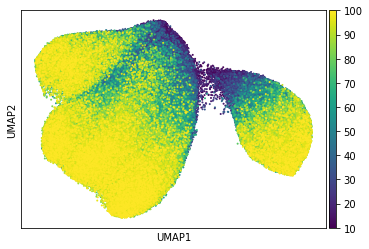

In [45]:
adata_counts = adata.copy()
adata_counts.obsm['latent'] = P_projected

calcUmap(adata_counts, nr_latent_dims=14)
plotUmap(adata_counts, color="n_spots")

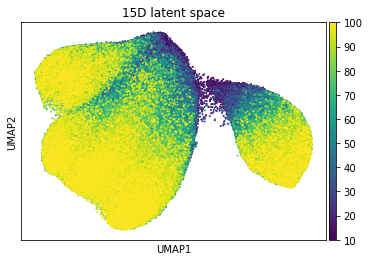

In [49]:
fig = sc.pl.umap(adata, color="n_spots", title="15D latent space", s=16, legend_fontsize = 20, return_fig = True)
plt.show()

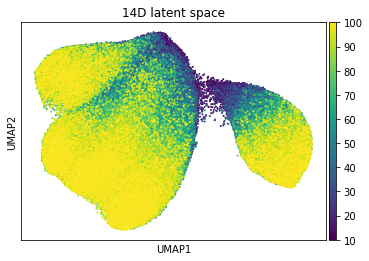

In [48]:
fig = sc.pl.umap(adata_counts, color="n_spots", title="14D latent space", s=16, legend_fontsize = 20, return_fig = True)
plt.show()

I don't see a difference in UMAP, so will do another regression of counts onto the 14D latent space to see if it still significantly correlates with some latent dimensions. If it does, then probably the projection was either done wrong or didn't help.
Conclusion: pretty sure that the projection is wrong, also cause I ended up with a 15D matrix iso a 14D. 

In [50]:
model = lm.OLS(endog = adata_counts.obs['n_spots'], exog=adata_counts.obsm['latent']).fit(cov_type='HC3')
model.summary()

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 3
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                n_spots   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                          1.222e+12
Date:                Mon, 25 Mar 2024   Prob (F-statistic):                        0.00
Time:                        14:09:40   Log-Likelihood:                     -9.3814e+05
No. Observations:              220687   AIC:                                  1.876e+06
Df Residuals:                  220686   BIC:                                  1.876e+06
Df Model:                           1                                                  
Covariance Type:                  HC3                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.952e+09   1023.141   1.91e+06      0.000    1.95e+09    1.95e+09
x2         -4.875e+09   2554.932  -1.91e+06      0.000   -4.88e+09   -4.88e+09
x3         -2.769e+08    145.120  -1.91e+06      0.000   -2.77e+08   -2.77e+08
x4         -1.638e+09    858.565  -1.91e+06      0.000   -1.64e+09   -1.64e+09
x5         -7.525e+08    394.321  -1.91e+06      0.000   -7.52e+08   -7.52e+08
x6          1.084e+10   5682.950   1.91e+06      0.000    1.08e+10    1.08e+10
x7         -2.699e+08    141.463  -1.91e+06      0.000    -2.7e+08    -2.7e+08
x8          -7.39e+08    387.278  -1.91e+06      0.000   -7.39e+08   -7.39e+08
x9          4.177e+08    218.880   1.91e+06      0.000    4.18e+08    4.18e+08
x10        -2.558e+09   1340.527  -1.91e+06      0.000   -2.56e+09   -2.56e+09
x11        -1.206e+10   6322.107  -1.91e+06      0.000   -1.21e+10   -1.21e+10
x12        -1.624e+10   8508.359  -1.91e+06      0.000   -1.62e+10   -1.62e+10
x13        -3.055e+10    1.6e+04  -1.91e+06      0.000   -3.05e+10   -3.05e+10
x14        -1.664e+10   8720.137  -1.91e+06      0.000   -1.66e+10   -1.66e+10
==============================================================================
Omnibus:                     4305.845   Durbin-Watson:                   0.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4571.260
Skew:                           0.344   Prob(JB):                         0.00
Kurtosis:                       3.156   Cond. No.                     6.74e+17
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
[3] The smallest eigenvalue is 1.32e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [51]:
unit_count = count/np.linalg.norm(count)
unit_count

array([-0.08221411,  0.35801926,  0.06830888,  0.11437394, -0.25387939,
       -0.59527911,  0.01093526,  0.05770584, -0.03863509, -0.03256443,
       -0.22637673,  0.35081185, -0.46489556,  0.1732162 , -0.04531902])

In [59]:
P_complement = 1/(np.inner(unit_count, unit_count)) * np.outer(unit_count, unit_count)
P = np.identity(15) - P_complement

In [60]:
Project = np.dot(adata.obsm['latent'], P)
Project.shape

(220687, 15)

In [61]:
model = lm.OLS(endog = adata_counts.obs['n_spots'], exog=Project).fit(cov_type='HC3')
model.summary()

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                n_spots   R-squared (uncentered):                   0.905
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                          1.551e+05
Date:                Mon, 25 Mar 2024   Prob (F-statistic):                        0.00
Time:                        14:49:39   Log-Likelihood:                     -9.6034e+05
No. Observations:              220687   AIC:                                  1.921e+06
Df Residuals:                  220673   BIC:                                  1.921e+06
Df Model:                          14                                                  
Covariance Type:                  HC3                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -6.4687      0.041   -159.257      0.000      -6.548      -6.389
x2            -1.3263      0.048    -27.718      0.000      -1.420      -1.233
x3            -2.9675      0.050    -59.487      0.000      -3.065      -2.870
x4             3.3357      0.039     86.195      0.000       3.260       3.412
x5            -2.5792      0.047    -55.091      0.000      -2.671      -2.487
x6            -1.7672      0.042    -42.057      0.000      -1.850      -1.685
x7            -3.7058      0.029   -129.912      0.000      -3.762      -3.650
x8            -0.3075      0.041     -7.434      0.000      -0.389      -0.226
x9             2.7140      0.028     95.679      0.000       2.658       2.770
x10            1.4574      0.033     44.503      0.000       1.393       1.522
x11           -1.8369      0.040    -46.333      0.000      -1.915      -1.759
x12           -1.5048      0.041    -36.314      0.000      -1.586      -1.424
x13            2.3436      0.042     56.407      0.000       2.262       2.425
x14           -2.0552      0.027    -76.920      0.000      -2.108      -2.003
x15            3.8496      0.041     93.433      0.000       3.769       3.930
==============================================================================
Omnibus:                     2482.827   Durbin-Watson:                   0.635
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2566.183
Skew:                           0.263   Prob(JB):                         0.00
Kurtosis:                       2.962   Cond. No.                     2.73e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
[3] The smallest eigenvalue is 5.52e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
# Step 1: Compute the projection matrix P_proj
P_proj = np.outer(count, count)

# Step 2: Compute the projected matrix P
P = np.dot(adata.obsm['latent'], P_proj)

P.view()

In [46]:
adata_counts

AnnData object with n_obs × n_vars = 220687 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'blur_interval', 'prop', 'prop_interval', 'corresponding_dapis', 'original_image_paths', 'binary_classified', 'classified', 'pattern_classified', 'cell-edge', 'extranuclear', 'intranuclear', 'pericellular', 'perinuclear', 'random', 'random_score', 'pattern_score', 'batch'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'latent', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
model = smf.ols("n_spots ~ dim0 + dim1 + dim2 + dim3 + dim4 + dim5 + dim6 + dim7 + dim8 + dim9 + dim10 + dim11 + dim12 + dim13 + dim14", data= df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_spots   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                 5.837e+04
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:30:39   Log-Likelihood:            -8.5705e+05
No. Observations:              220687   AIC:                         1.714e+06
Df Residuals:                  220671   BIC:                         1.714e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    502.9800      1.028    489.099      0.000     500.964     504.996
dim0          -6.4150      0.033   -191.547      0.000      -6.481      -6.349
dim1          -9.1846      0.041   -221.984      0.000      -9.266      -9.104
dim2           3.2046      0.033     97.153      0.000       3.140       3.269
dim3         -12.4313      0.037   -337.819      0.000     -12.503     -12.359
dim4          10.5681      0.039    272.062      0.000      10.492      10.644
dim5          -7.1314      0.028   -254.556      0.000      -7.186      -7.076
dim6          -8.8824      0.028   -314.642      0.000      -8.938      -8.827
dim7          -5.2621      0.028   -188.718      0.000      -5.317      -5.207
dim8          12.4963      0.033    378.108      0.000      12.432      12.561
dim9           9.5861      0.029    330.212      0.000       9.529       9.643
dim10         -0.0331      0.026     -1.292      0.196      -0.083       0.017
dim11         -5.2253      0.033   -157.434      0.000      -5.290      -5.160
dim12         15.8990      0.052    303.259      0.000      15.796      16.002
dim13         14.7264      0.033    440.240      0.000      14.661      14.792
dim14        -13.6178      0.039   -345.411      0.000     -13.695     -13.540
==============================================================================
Omnibus:                     9057.402   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11001.262
Skew:                           0.462   Prob(JB):                         0.00
Kurtosis:                       3.584   Cond. No.                         622.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
#heteroscedacity testing
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 15725.368956379645),
 ('p-value', 0.0),
 ('f-value', 1128.7097574650388),
 ('f p-value', 0.0)]

So there is significant deviation of normality of the residuals, however it seems that that is because of the spot count being uniformly sampled iso with a normal distribution. The Q-Q plot of the residuals seems normal enough, so I'm not going to change anything

In [54]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
lzip(name, test)

[('Jarque-Bera', 11001.261616866985),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 0.46230814149458044),
 ('Kurtosis', 3.58436831217331)]

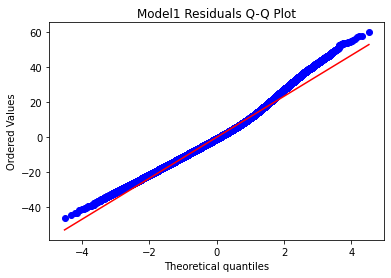

In [58]:
#Running plot & giving it a title
stats.probplot(model.resid, dist="norm", plot= plt)
plt.title("Model1 Residuals Q-Q Plot")

#Saving plot as a png
plt.savefig("Model1_Resid_qqplot.png")

(array([2307., 2563., 2607., 2230., 2452., 2454., 2361., 2497., 2227.,
           0., 2388., 2267., 2304., 2298., 2396., 2263., 2331., 2359.,
        2419.,    0., 2415., 2285., 2240., 2516., 2333., 2364., 2578.,
        2506., 2519.,    0., 2581., 2586., 2500., 2472., 2494., 2556.,
        2397., 2432., 2349.,    0., 2395., 2462., 2436., 2390., 2610.,
        2442., 2503., 2416., 2451.,    0., 2361., 2196., 2374., 2576.,
        2368., 2451., 2489., 2293., 2446.,    0., 2440., 2592., 2394.,
        2493., 2382., 2529., 2466., 2333., 2391.,    0., 2388., 2418.,
        2495., 2374., 2382., 2496., 2383., 2417., 2454.,    0., 2534.,
        2499., 2484., 2403., 2413., 2439., 2519., 2296., 2392.,    0.,
        2422., 2647., 2356., 2421., 2447., 2405., 2427., 2345., 2246.,
        2660.]),
 array([ 10. ,  10.9,  11.8,  12.7,  13.6,  14.5,  15.4,  16.3,  17.2,
         18.1,  19. ,  19.9,  20.8,  21.7,  22.6,  23.5,  24.4,  25.3,
         26.2,  27.1,  28. ,  28.9,  29.8,  30.7,  31.6,  32

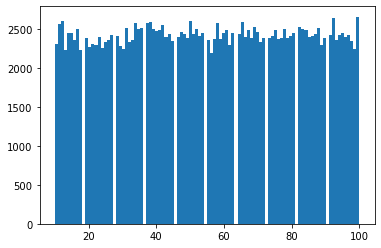

In [57]:
plt.hist(x=adata.obs['n_spots'], bins=100)

In [55]:
# There is evidence for positive serial correlation between the errors. (so probably assumption of independent errors is violated)
statsmodels.stats.stattools.durbin_watson(model.resid)

0.6591092010173236

In [59]:
model = smf.ols("n_spots ~ dim0 + dim1 + dim2 + dim3 + dim4 + dim5 + dim6 + dim7 + dim8 + dim9 + dim10 + dim11 + dim12 + dim13 + dim14", data= df).fit(cov_type='HC3')

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_spots   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                 8.331e+04
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:44:49   Log-Likelihood:            -8.5705e+05
No. Observations:              220687   AIC:                         1.714e+06
Df Residuals:                  220671   BIC:                         1.714e+06
Df Model:                          15                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    502.9800      1.045    481.298      0.000     500.932     505.028
dim0          -6.4150      0.034   -186.306      0.000      -6.483      -6.348
dim1          -9.1846      0.042   -216.175      0.000      -9.268      -9.101
dim2           3.2046      0.034     93.614      0.000       3.137       3.272
dim3         -12.4313      0.038   -325.756      0.000     -12.506     -12.356
dim4          10.5681      0.040    265.012      0.000      10.490      10.646
dim5          -7.1314      0.029   -247.827      0.000      -7.188      -7.075
dim6          -8.8824      0.030   -300.810      0.000      -8.940      -8.825
dim7          -5.2621      0.029   -181.650      0.000      -5.319      -5.205
dim8          12.4963      0.033    374.898      0.000      12.431      12.562
dim9           9.5861      0.030    324.096      0.000       9.528       9.644
dim10         -0.0331      0.027     -1.225      0.221      -0.086       0.020
dim11         -5.2253      0.035   -149.791      0.000      -5.294      -5.157
dim12         15.8990      0.054    295.051      0.000      15.793      16.005
dim13         14.7264      0.034    433.667      0.000      14.660      14.793
dim14        -13.6178      0.041   -334.150      0.000     -13.698     -13.538
==============================================================================
Omnibus:                     9057.402   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11001.262
Skew:                           0.462   Prob(JB):                         0.00
Kurtosis:                       3.584   Cond. No.                         622.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

## Making latent space count invariant using batch-effect correction methods

We'll make bins for the different cell counts. Probably will do 0-20, 20-40, 40-60, 60-80, 81+
Then that is used as an input into the harmony running

In [85]:
count_bin = pd.cut(adata.obs['n_spots'], bins=5, labels=["bin 0", "bin 1", "bin 2", "bin 3", "bin 4"], ordered=True)
count_bin.value_counts()

bin 0    45138
bin 1    44103
bin 3    43921
bin 4    43821
bin 2    43704
Name: n_spots, dtype: int64

In [86]:
adata.obs['n_spots_bin'] = count_bin
adata.obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,blur_interval,...,cell-edge,extranuclear,intranuclear,pericellular,perinuclear,random,random_score,pattern_score,batch,n_spots_bin
0,cell-edge,pattern,100,100+,149,blank,124,120-180,1.5,NaN,...,9.985172e-01,0.422161,2.038958e-18,8.139958e-18,1.522162e-11,0.999980,0.806723,0.193872,0,bin 4
1,cell-edge,pattern,100,100+,149,blank,161,120-180,1.5,NaN,...,9.996459e-01,0.938447,9.300263e-20,9.723175e-17,1.278433e-09,0.999978,0.786449,0.214457,0,bin 4
2,cell-edge,pattern,100,100+,149,blank,57,0-60,1.5,NaN,...,9.929121e-01,0.868868,2.720590e-19,1.327658e-16,1.400917e-09,0.997670,0.613716,0.387979,0,bin 4
3,cell-edge,pattern,100,100+,149,blank,96,60-120,1.5,NaN,...,9.974719e-01,0.683816,2.393022e-18,1.593811e-17,2.160465e-10,0.999952,0.816660,0.184197,0,bin 4
4,cell-edge,pattern,100,100+,272,blank,245,240-300,1.5,NaN,...,9.991395e-01,0.997390,2.491777e-19,1.006105e-10,3.958879e-08,0.007829,0.058782,0.941308,0,bin 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220682,random,random,99,100+,80,blank,193,180-240,1.5,NaN,...,2.101227e-05,0.004966,9.210425e-13,2.441267e-30,3.942036e-05,1.000000,0.999117,0.000895,0,bin 4
220683,random,random,99,100+,80,blank,196,180-240,1.5,NaN,...,1.683812e-07,0.002076,2.011644e-14,6.885430e-33,5.124744e-05,1.000000,0.998786,0.001229,0,bin 4
220684,random,random,99,100+,80,blank,247,240-300,1.5,NaN,...,3.827430e-04,0.000675,6.427072e-12,2.209788e-29,3.792834e-07,1.000000,0.998853,0.001155,0,bin 4
220685,random,random,99,100+,80,blank,302,300+,1.5,NaN,...,1.809081e-08,0.000406,4.297435e-13,2.204371e-32,2.143221e-03,1.000000,0.998953,0.001053,0,bin 4


In [89]:
import harmonypy as hm
ho = hm.run_harmony(data_mat=adata.obsm['latent'], meta_data=adata.obs, vars_use='n_spots_bin')

# Write the adjusted PCs to a new file.
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

2024-03-25 16:31:40,425 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-25 16:32:18,047 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-25 16:32:18,612 - harmonypy - INFO - Iteration 1 of 10
2024-03-25 16:33:11,582 - harmonypy - INFO - Iteration 2 of 10
2024-03-25 16:34:04,298 - harmonypy - INFO - Iteration 3 of 10
2024-03-25 16:34:56,201 - harmonypy - INFO - Iteration 4 of 10
2024-03-25 16:35:11,976 - harmonypy - INFO - Iteration 5 of 10
2024-03-25 16:35:27,730 - harmonypy - INFO - Converged after 5 iterations


In [97]:
adata_batch = adata.copy()
adata_batch.obsm['latent'] = ho.Z_corr.transpose()

In [98]:
model = lm.OLS(endog = adata_batch.obs['n_spots'], exog=adata_batch.obsm['latent']).fit(cov_type='HC3')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                n_spots   R-squared (uncentered):                   0.815
Model:                            OLS   Adj. R-squared (uncentered):              0.815
Method:                 Least Squares   F-statistic:                          6.521e+04
Date:                Mon, 25 Mar 2024   Prob (F-statistic):                        0.00
Time:                        16:39:33   Log-Likelihood:                     -1.0341e+06
No. Observations:              220687   AIC:                                  2.068e+06
Df Residuals:                  220672   BIC:                                  2.068e+06
Df Model:                          15                                                  
Covariance Type:                  HC3                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4731      0.070      6.744      0.000       0.336       0.611
x2             1.5239      0.074     20.583      0.000       1.379       1.669
x3            -0.2738      0.073     -3.729      0.000      -0.418      -0.130
x4             1.4851      0.054     27.270      0.000       1.378       1.592
x5            -1.4833      0.064    -23.020      0.000      -1.610      -1.357
x6            -0.0756      0.065     -1.170      0.242      -0.202       0.051
x7             1.0023      0.048     20.949      0.000       0.909       1.096
x8             0.6928      0.057     12.261      0.000       0.582       0.804
x9            -1.3451      0.045    -29.974      0.000      -1.433      -1.257
x10           -0.9691      0.047    -20.812      0.000      -1.060      -0.878
x11           -0.5107      0.056     -9.113      0.000      -0.621      -0.401
x12            1.0153      0.064     15.826      0.000       0.890       1.141
x13           -2.3691      0.074    -32.033      0.000      -2.514      -2.224
x14           -1.1666      0.046    -25.578      0.000      -1.256      -1.077
x15            1.3149      0.065     20.263      0.000       1.188       1.442
==============================================================================
Omnibus:                   167900.200   Durbin-Watson:                   0.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12863.545
Skew:                          -0.004   Prob(JB):                         0.00
Kurtosis:                       1.817   Cond. No.                         35.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
"""

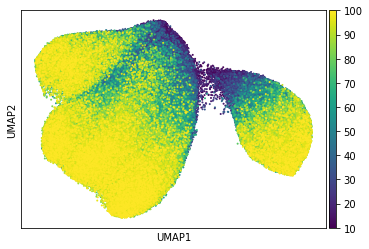

In [100]:
calcUmap(adata_batch)
plotUmap(adata_batch, color="n_spots")

In [12]:
counts = adata.obs['n_spots'].astype('str')
adata.obs['counts'] = counts


,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,blur_interval,...,cell-edge,extranuclear,intranuclear,pericellular,perinuclear,random,random_score,pattern_score,batch,counts
0,cell-edge,pattern,100,100+,149,blank,124,120-180,1.5,NaN,...,9.985172e-01,0.422161,2.038958e-18,8.139958e-18,1.522162e-11,0.999980,0.806723,0.193872,0,100
1,cell-edge,pattern,100,100+,149,blank,161,120-180,1.5,NaN,...,9.996459e-01,0.938447,9.300263e-20,9.723175e-17,1.278433e-09,0.999978,0.786449,0.214457,0,100
2,cell-edge,pattern,100,100+,149,blank,57,0-60,1.5,NaN,...,9.929121e-01,0.868868,2.720590e-19,1.327658e-16,1.400917e-09,0.997670,0.613716,0.387979,0,100
3,cell-edge,pattern,100,100+,149,blank,96,60-120,1.5,NaN,...,9.974719e-01,0.683816,2.393022e-18,1.593811e-17,2.160465e-10,0.999952,0.816660,0.184197,0,100
4,cell-edge,pattern,100,100+,272,blank,245,240-300,1.5,NaN,...,9.991395e-01,0.997390,2.491777e-19,1.006105e-10,3.958879e-08,0.007829,0.058782,0.941308,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220682,random,random,99,100+,80,blank,193,180-240,1.5,NaN,...,2.101227e-05,0.004966,9.210425e-13,2.441267e-30,3.942036e-05,1.000000,0.999117,0.000895,0,99
220683,random,random,99,100+,80,blank,196,180-240,1.5,NaN,...,1.683812e-07,0.002076,2.011644e-14,6.885430e-33,5.124744e-05,1.000000,0.998786,0.001229,0,99
220684,random,random,99,100+,80,blank,247,240-300,1.5,NaN,...,3.827430e-04,0.000675,6.427072e-12,2.209788e-29,3.792834e-07,1.000000,0.998853,0.001155,0,99
220685,random,random,99,100+,80,blank,302,300+,1.5,NaN,...,1.809081e-08,0.000406,4.297435e-13,2.204371e-32,2.143221e-03,1.000000,0.998953,0.001053,0,99


In [14]:
adata.obs['counts']
adata.obs['n_spots']

0         100
1         100
2         100
3         100
4         100
         ... 
220682     99
220683     99
220684     99
220685     99
220686     99
Name: n_spots, Length: 220687, dtype: int64

In [15]:
import harmonypy as hm
ho = hm.run_harmony(data_mat=adata.obsm['latent'], meta_data=adata.obs, vars_use='counts')

# Write the adjusted PCs to a new file.
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

2024-03-26 09:46:31,956 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-26 09:46:57,281 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-26 09:46:57,949 - harmonypy - INFO - Iteration 1 of 10
2024-03-26 09:48:10,944 - harmonypy - INFO - Iteration 2 of 10
2024-03-26 09:49:22,008 - harmonypy - INFO - Iteration 3 of 10
2024-03-26 09:50:30,585 - harmonypy - INFO - Iteration 4 of 10
2024-03-26 09:51:00,300 - harmonypy - INFO - Iteration 5 of 10
2024-03-26 09:51:30,156 - harmonypy - INFO - Converged after 5 iterations


In [16]:
adata_batch = adata.copy()
adata_batch.obsm['latent'] = ho.Z_corr.transpose()

In [17]:
model = lm.OLS(endog = adata_batch.obs['n_spots'], exog=adata_batch.obsm['latent']).fit(cov_type='HC3')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                n_spots   R-squared (uncentered):                   0.815
Model:                            OLS   Adj. R-squared (uncentered):              0.815
Method:                 Least Squares   F-statistic:                          6.513e+04
Date:                Tue, 26 Mar 2024   Prob (F-statistic):                        0.00
Time:                        09:53:10   Log-Likelihood:                     -1.0342e+06
No. Observations:              220687   AIC:                                  2.068e+06
Df Residuals:                  220672   BIC:                                  2.069e+06
Df Model:                          15                                                  
Covariance Type:                  HC3                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4746      0.070      6.762      0.000       0.337       0.612
x2             1.4586      0.074     19.681      0.000       1.313       1.604
x3            -0.2365      0.073     -3.218      0.001      -0.380      -0.092
x4             1.5006      0.054     27.538      0.000       1.394       1.607
x5            -1.4795      0.064    -22.954      0.000      -1.606      -1.353
x6            -0.0300      0.065     -0.462      0.644      -0.157       0.097
x7             1.0247      0.048     21.410      0.000       0.931       1.119
x8             0.6616      0.057     11.704      0.000       0.551       0.772
x9            -1.3606      0.045    -30.307      0.000      -1.449      -1.273
x10           -0.9571      0.047    -20.541      0.000      -1.048      -0.866
x11           -0.4961      0.056     -8.837      0.000      -0.606      -0.386
x12            0.9415      0.064     14.653      0.000       0.816       1.067
x13           -2.3308      0.074    -31.490      0.000      -2.476      -2.186
x14           -1.2276      0.046    -26.882      0.000      -1.317      -1.138
x15            1.3714      0.065     21.126      0.000       1.244       1.499
==============================================================================
Omnibus:                   164352.093   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12809.024
Skew:                          -0.004   Prob(JB):                         0.00
Kurtosis:                       1.820   Cond. No.                         35.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
"""

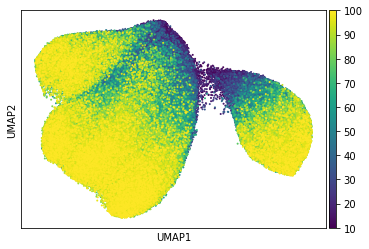

In [18]:
calcUmap(adata_batch)
plotUmap(adata_batch, color="n_spots")